## Fine tuning classification with OpenAI

리뷰어가 아이템에 줄 별점 수를 분류하기 위해 ada 분류기를 fine-tuning 한다.








### Load Data

In [1]:
!pip install datasets
!pip install openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.2 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.5/325.5 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 1.2 MB/s eta

In [2]:
# 필요한 라이브러리 임포트
import pandas as pd  # 데이터 조작 및 분석에 사용
from openai import OpenAI  # OpenAI의 AI 모델에 접근하기 위한 API
import os  # 운영 체제와 상호 작용하는 함수 제공
from datasets import load_dataset  # 데이터셋을 로드하고 전처리하기 위한 라이브러리
import random  # 난수 생성을 위한 함수 제공
import math  # 수학 함수 제공
import matplotlib.pyplot as plt
import json
import seaborn as sns  # Seaborn은 플롯 스타일링을 위한 고수준 인터페이스 제공
import numpy as np
from tqdm.auto import tqdm
import math
import base64

# 스타일을 현대적인 외관으로 설정
sns.set_style("whitegrid")

# 무작위 작업의 재현성을 위한 상수 SEED 정의
SEED = 42

# 일관된 결과를 보장하기 위해 random 라이브러리의 시드 설정
random.seed(SEED)

In [3]:
OpenAI.api_key = os.getenv("")

# client = OpenAI(
#     # This is the default and can be omitted
#     api_key=os.environ.get(""),
# )

'star'는 데이터셋의 열 중 하나이며, 샘플을 계층화할 수 있도록 ClassLabel 열로 변환한다.

In [4]:
# 범주형 클래스 레이블을 나타내기 위해 ClassLabel 모듈을 임포트
from datasets import ClassLabel

# 아마존 리뷰 다운 언어 데이터셋 로드
dataset = load_dataset("app_reviews", split='train')

# 데이터셋의 'star' 열을 ClassLabel 유형으로 변환
# 이는 범주형 표현을 가능하게 하고 클래스 처리를 더 쉽게 한다.
dataset = dataset.class_encode_column('star')

dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/288065 [00:00<?, ? examples/s]

Stringifying the column:   0%|          | 0/288065 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/288065 [00:00<?, ? examples/s]

Dataset({
    features: ['package_name', 'review', 'date', 'star'],
    num_rows: 288065
})

- ```class_encode_column```
    - datasets 라이브러리에서 제공하는 함수로, 특정 열을 범주형(ClassLabel) 타입으로 변환한다.
    - 이를 통해 해당 열의 값을 클래스 레이블로 간주하고, 데이터셋을 더 효율적으로 처리할 수 있다.
    - 특히, 머신 러닝 모델을 훈련시킬 때 범주형 데이터를 다루기 쉽도록 한다.

In [5]:
# 데이터셋을 학습 세트와 테스트 세트로 분할한다.
# 데이터의 20%를 테스트 용도로 설정하고, 'star' 열에서 계층화를 사용하여, 두 세트가 각 별점 범주의 동일한 분포를 가지도록 한다.
dataset = dataset.train_test_split(test_size=0.2, seed=SEED, stratify_by_column='star')

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['package_name', 'review', 'date', 'star'],
        num_rows: 230452
    })
    test: Dataset({
        features: ['package_name', 'review', 'date', 'star'],
        num_rows: 57613
    })
})

In [7]:
# 이제 학습 데이터셋을 더 분할하여 25%를 검증 데이터 셋을 분리한다.
# 다시 한 번, 'star' 열에서 계층화를 사용하여 분포를 일관되게 유지한다.
df = dataset['train'].train_test_split(test_size=.25, seed=SEED, stratify_by_column='star')

In [8]:
df

DatasetDict({
    train: Dataset({
        features: ['package_name', 'review', 'date', 'star'],
        num_rows: 172839
    })
    test: Dataset({
        features: ['package_name', 'review', 'date', 'star'],
        num_rows: 57613
    })
})

In [9]:
# 분할된 데이터셋을 각각의 키에 할당한다.
# - 초기 학습 데이터의 나머지 75%는 새로운 학습 데이터셋이 된다.
dataset['train'] = df['train']
# - 초기 학습 데이터의 25%는 검증 데이터셋이 된다.
dataset['val'] = df['test']

In [10]:
dataset

DatasetDict({
    train: Dataset({
        features: ['package_name', 'review', 'date', 'star'],
        num_rows: 172839
    })
    test: Dataset({
        features: ['package_name', 'review', 'date', 'star'],
        num_rows: 57613
    })
    val: Dataset({
        features: ['package_name', 'review', 'date', 'star'],
        num_rows: 57613
    })
})

```dataset.train_test_split```

- ```dataset.train_test_split(test_size=0.2, seed=SEED, stratify_by_column='star')```
    - 데이터셋을 학습 세트와 테스트 세트로 분할한다.
    - ```test_size=0.2```: 전체 데이터의 20%를 테스트 데이터로 사용한다.
    - ```seed=SEED```: 무작위 분할의 재현성을 위해 시드를 설정한다.
    - ```stratify_by_column='star'```: 'star' 열을 기준으로 계층화하여 분포를 유지한다.

In [11]:
# pandas DataFrame으로 변환
training_df = pd.DataFrame(dataset['train'])
training_df.head()

,package_name,review,date,star
0,org.ppsspp.ppsspp,Nice😉,March 09 2017,4
1,com.google.android.gms,Google play service Just one ward its amazing ...,December 18 2016,4
2,com.google.android.gms,Mr Perfect,April 30 2017,0
3,org.torproject.android,Does not work with Tmobile S4 If you try to in...,September 08 2016,0
4,com.google.android.gms,Ok,April 29 2017,2


In [12]:
training_df[['review']].sample(5)

,review
45315,Aggravating Scanner takes too long to focus an...
118589,Good app This is very useful for knowledge suc...
75583,It works great for what I do.
79092,Ak Love
67545,If you hate to re-type ?out this great app! Af...


In [13]:
# 각 'star' 값의 발생 횟수를 세고, 인덱스별로 정렬한다.
star_counts = training_df['star'].value_counts().sort_index()
star_counts

star
0     23990
1      7958
2     13918
3     22349
4    104624
Name: count, dtype: int64

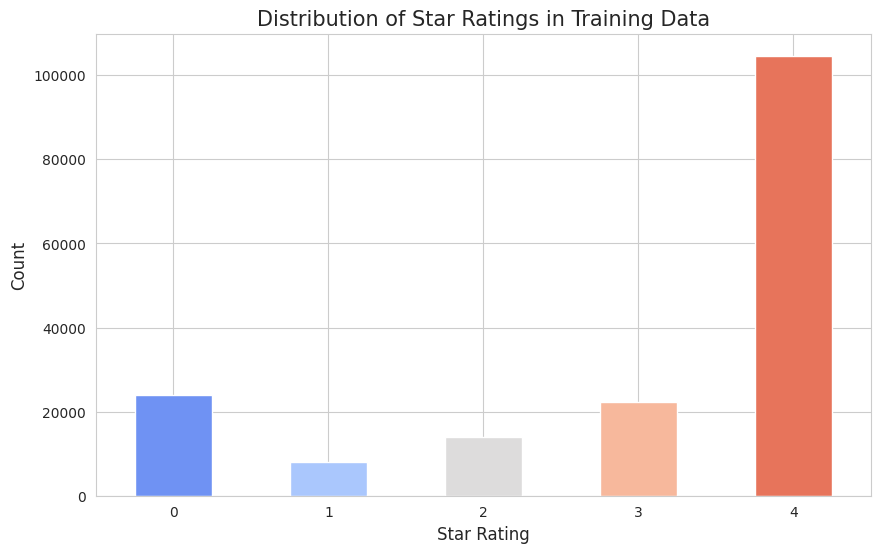

In [14]:
# 주어진 별점의 분포를 보여주는 막대 그래프를 생성한다.
plt.figure(figsize=(10, 6))
star_counts.plot(kind='bar', color=sns.color_palette("coolwarm", len(star_counts)))

plt.title('Distribution of Star Ratings in Training Data', fontsize=15)
plt.xlabel('Star Rating', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0)

plt.show()

1. **`value_counts()`**:
   - 데이터프레임의 특정 열에 있는 값의 빈도수를 계산한다.
   - 여기서는 `training_df['star']` 열의 각 별점 값이 몇 번 나오는지 계산한다.

2. **`sort_index()`**:
   - 인덱스를 기준으로 값을 정렬한다.
   - `value_counts()` 함수로 계산된 별점 빈도수를 인덱스(별점 값) 기준으로 정렬한다.

3. **`plot(kind='bar', color=sns.color_palette("coolwarm", len(star_counts)))`**:
   - `plot` 함수는 데이터프레임이나 시리즈 객체에서 그래프를 그리는 데 사용된다.
   - `kind='bar'`는 막대 그래프를 생성하도록 지정한다.
   - `color=sns.color_palette("coolwarm", len(star_counts))`는 막대의 색상을 설정한다. 여기서는 `coolwarm` 팔레트를 사용하여 별점의 개수에 맞게 색상을 지정한다.

4. **`plt.xticks(rotation=0)`**:
   - x축의 틱 라벨의 회전 각도를 설정한다.
   - `rotation=0`은 라벨이 수평으로 표시되도록 설정한다.

In [15]:
test_df = pd.DataFrame(dataset['test'])
val_df = pd.DataFrame(dataset['val'])

### Star prediction (sentiment)

In [16]:
# 각 데이터셋(학습, 검증, 테스트)에서 'review' 열에 구분자 '###\n'을 추가하여 'prompt' 열을 만든다.
# 이 구분자는 fine-tuning 시 프롬프트가 끝나고 예상 출력이 시작되는 지점을 표시하는 데 자주 사용된다.
training_df['prompt'] = training_df['review'] + '\n###\n'
val_df['prompt'] = val_df['review'] + '\n###\n'
test_df['prompt'] = test_df['review'] + '\n###\n'

In [17]:
training_df.head(5)

,package_name,review,date,star,prompt
0,org.ppsspp.ppsspp,Nice😉,March 09 2017,4,Nice😉\n###\n
1,com.google.android.gms,Google play service Just one ward its amazing ...,December 18 2016,4,Google play service Just one ward its amazing ...
2,com.google.android.gms,Mr Perfect,April 30 2017,0,Mr Perfect\n###\n
3,org.torproject.android,Does not work with Tmobile S4 If you try to in...,September 08 2016,0,Does not work with Tmobile S4 If you try to in...
4,com.google.android.gms,Ok,April 29 2017,2,Ok\n###\n


In [18]:
# 각 데이터셋의 'star' 열을 문자열 형식으로 변환하고 'completion' 열에 저장한다.
# 'completion' 열은 감정 분석의 목표 변수로 사용된다.
training_df['completion'] = training_df['star'].astype(str)
val_df['completion'] = val_df['star'].astype(str)
test_df['completion'] = test_df['star'].astype(str)

In [19]:
training_df.head(5)

,package_name,review,date,star,prompt,completion
0,org.ppsspp.ppsspp,Nice😉,March 09 2017,4,Nice😉\n###\n,4
1,com.google.android.gms,Google play service Just one ward its amazing ...,December 18 2016,4,Google play service Just one ward its amazing ...,4
2,com.google.android.gms,Mr Perfect,April 30 2017,0,Mr Perfect\n###\n,0
3,org.torproject.android,Does not work with Tmobile S4 If you try to in...,September 08 2016,0,Does not work with Tmobile S4 If you try to in...,0
4,com.google.android.gms,Ok,April 29 2017,2,Ok\n###\n,2


In [20]:
# 'prompt' 열을 기준으로 중복을 제거한 후, JSONL 형식의 학습 데이터셋을 생성한다.
# 무작위 샘플링은 데이터가 섞이도록 해준다.
training_df.sample(len(training_df)).drop_duplicates(subset=['prompt'])[['prompt', 'completion']].to_json(
    "app-review-full-train-sentiment-random.jsonl", orient='records', lines=True
)

In [21]:
import json

data_list = []
with open("./app-review-full-train-sentiment-random.jsonl", "r") as f:
    for line in f:
        data_list.append( json.loads(line) )

data_list[:5]

[{'prompt': 'Best Very best service\n###\n', 'completion': '3'},
 {'prompt': 'I want you delete unnecessary data from other channels. So much of non sense data in other channel.please provide us the access to delete the unwanted day from other channel\n###\n',
  'completion': '1'},
 {'prompt': 'Great app Nice app\n###\n', 'completion': '4'},
 {'prompt': 'Suma Super\n###\n', 'completion': '1'},
 {'prompt': 'First and Last! Love the app. Has all I need. Three questions: 1) how do I donate  2) how do I use the PasswordSafe keyboard?  3) any future plans for including stronger encryption algorithms?\n###\n',
  'completion': '4'}]

In [22]:
# 이번에는 'completion' 열(별점) 순서대로 정렬된 JSONL 형식의 학습 데이터셋을 생성한다.
# 이 정렬된 데이터셋은 특정 학습 전략에 유용할 수 있다.
training_df.sample(len(training_df)).drop_duplicates(subset=['prompt'])[['prompt', 'completion']].sort_values('completion').to_json(
    "app-review-full-train-sentiment-ordered.jsonl", orient='records', lines=True
)

In [23]:
import json

data_list = []
with open("./app-review-full-train-sentiment-ordered.jsonl", "r") as f:
    for line in f:
        data_list.append( json.loads(line) )

data_list[:5]

[{'prompt': 'App crashes when trying to connect to my rTorrent server.\n###\n',
  'completion': '0'},
 {'prompt': 'This app is OK but I can only give 1 star due to the lack of Widget support. Please add it in the future version.\n###\n',
  'completion': '0'},
 {'prompt': 'Please Tell me what to do It tells me to activate the notificafion permission then it takes me to the notification center where the notification permission is already active.I get back into the app it tells me that the notification permission is not active.What can I do?\n###\n',
  'completion': '0'},
 {'prompt': 'Invalid qt Galaxy S7 active. Invalid qt  unable to download libs.\n###\n',
  'completion': '0'},
 {'prompt': 'It deleted all my songs it suck do not do not!! It sucks balls\n###\n',
  'completion': '0'}]

In [24]:
# 'prompt' 열을 기준으로 중복을 제거한 후, JSONL 형식의 검증 데이터셋을 생성한다.
val_df.sample(len(val_df)).drop_duplicates(subset=['prompt'])[['prompt', 'completion']].to_json(
    "app-review-full-val-sentiment-random.jsonl", orient='records', lines=True
)

In [25]:
import json

data_list = []
with open("app-review-full-val-sentiment-random.jsonl", "r") as f:
    for line in f:
        data_list.append( json.loads(line) )

data_list[:5]

[{'prompt': 'Very useful for choosing a channel in a crowded WiFi band\n###\n',
  'completion': '4'},
 {'prompt': 'Its okAy\n###\n', 'completion': '3'},
 {'prompt': 'Naruto\n###\n', 'completion': '4'},
 {'prompt': 'I love Google team\n###\n', 'completion': '4'},
 {'prompt': 'I love it I love it\n###\n', 'completion': '4'}]

In [26]:
# 'prompt' 열을 기준으로 중복을 제거한 후, JSONL 형식의 테스트 데이터셋을 생성한다.
test_df.sample(len(test_df)).drop_duplicates(subset=['prompt'])[['prompt', 'completion']].to_json(
    "app-review-full-test-sentiment-random.jsonl", orient='records', lines=True
)

In [27]:
import json

data_list = []
with open("app-review-full-test-sentiment-random.jsonl", "r") as f:
    for line in f:
        data_list.append( json.loads(line) )

data_list[:5]

[{'prompt': 'Gogle services Internal\n###\n', 'completion': '2'},
 {'prompt': "Believe If you don't believe it won't be\n###\n",
  'completion': '4'},
 {'prompt': 'Good Mykola\n###\n', 'completion': '4'},
 {'prompt': 'Great Blessing\n###\n', 'completion': '4'},
 {'prompt': 'easy to use very easy to use! it made the jump from the iOS environment to android a lot easier (my contacts and appointments are still in icloud). it also has a nice UI.\n###\n',
  'completion': '4'}]

#### 사용된 코드의 목적
이 코드는 각 데이터셋(학습, 검증, 테스트)을 JSONL 형식으로 저장하는 과정을 포함한다. JSONL 형식은 줄마다 하나의 JSON 객체가 있는 형태로, 텍스트 데이터를 다루는 데 유용하다. 이 코드에서는 각 리뷰에 구분자를 추가하여 프롬프트를 만들고, 별점을 문자열 형식으로 변환하여 완료 항목으로 사용한다. 데이터셋은 중복 항목을 제거한 후 무작위로 샘플링하여 저장되며, 일부 데이터셋은 별점 순서대로 정렬하여 저장된다.

### 사용된 함수에 대한 설명

1. **`df['column'].astype(str)`**:
   - 데이터프레임의 특정 열을 문자열 형식으로 변환한다.
   - 예: `training_df['star'].astype(str)`는 'star' 열을 문자열로 변환한다.

2. **`df.sample(len(df))`**:
   - 데이터프레임을 무작위로 샘플링하여 원래의 행 수를 유지한다.
   - 예: `training_df.sample(len(training_df))`는 'training_df'의 모든 행을 무작위로 섞는다.

3. **`df.drop_duplicates(subset=['column'])`**:
   - 지정된 열을 기준으로 중복 행을 제거한다.
   - 예: `training_df.drop_duplicates(subset=['prompt'])`는 'prompt' 열에서 중복된 행을 제거한다.

4. **`df[['column1', 'column2']].to_json("file.jsonl", orient='records', lines=True)`**:
   - 데이터프레임의 특정 열을 선택하고 JSONL 형식으로 저장한다.
   - `orient='records'`는 각 행을 JSON 객체로 변환한다.
   - `lines=True`는 각 JSON 객체를 별도의 줄에 저장한다.
   - 예: `training_df[['prompt', 'completion']].to_json("app-review-full-train-sentiment-random.jsonl", orient='records', lines=True)`는 'prompt'와 'completion' 열을 JSONL 파일로 저장한다.

5. **`df.sort_values('column')`**:
   - 지정된 열을 기준으로 데이터프레임을 정렬한다.
   - 예: `training_df.sort_values('completion')`는 'completion' 열을 기준으로 데이터프레임을 정렬한다.

In [28]:
def get_data_dict(row, system=''):
    return {
        "messages": [
            {"role": "system", "content": system},
            {"role": "user", "content": row['review']},
            {"role": "assistant", "content": str(row['star'])}
        ]
    }

In [29]:
# 시스템 프롬프트 없이 3.5 프롬프트를 내보낸다.
with open(f'app-review-full-train-sentiment-random-3.5.jsonl', 'w') as f:
    for index, row in training_df.iterrows():
        json_str = json.dumps(get_data_dict(row))
        f.write(json_str + '\n')

In [30]:
with open(f'app-review-full-test-sentiment-random-3.5.jsonl', 'w') as f:
    for index, row in test_df.iterrows():
        json_str = json.dumps(get_data_dict(row))
        f.write(json_str + '\n')

In [31]:
with open(f'app-review-full-val-sentiment-random-3.5.jsonl', 'w') as f:
    for index, row in val_df.iterrows():
        json_str = json.dumps(get_data_dict(row))
        f.write(json_str + '\n')

#### 각 코드의 의미와 사용된 함수 설명

1. **`get_data_dict(row, system='')`**:
   - 주어진 행(row) 데이터를 사용하여 사전(dictionary) 형식으로 변환한다.
   - `messages` 키는 역할(role)과 내용(content)을 포함하는 리스트를 가진다.
     - `{"role": "system", "content": system}`: 시스템 메시지로, 기본값은 빈 문자열이다.
     - `{"role": "user", "content": row['review']}`: 사용자의 리뷰 내용을 포함한다.
     - `{"role": "assistant", "content": str(row['star'])}`: 리뷰의 별점을 문자열로 포함한다.

위 코드는 학습, 테스트 및 검증 데이터셋을 OpenAI의 GPT 모델에서 사용할 수 있는 형식으로 변환하여 JSONL 파일로 저장한다. 각 리뷰를 프롬프트로, 각 별점을 모델의 기대 출력으로 사용한다. 이를 통해 모델을 fine-tuning 할 때 사용자 리뷰와 별점 데이터를 효과적으로 사용할 수 있다.

#### 코드의 목적
이 코드는 리뷰 데이터를 JSON Lines(JSONL) 형식으로 변환하여 OpenAI GPT 모델을 학습시키기 위한 준비 작업이다. JSONL 형식은 각 줄에 하나의 JSON 객체를 포함하고 있어 대량의 텍스트 데이터를 저장하고 처리하는 데 적합하다. 여기서는 리뷰를 'user' 역할의 메시지로, 별점을 'assistant' 역할의 메시지로 설정하여 데이터셋을 구성한다.

In [32]:
# 시스템 프롬프트를 포함한 3.5 프롬프트를 내보낸다.
system_prompt = 'You predict star ratings given an app review from 0-4 where 0 means the review would give the worst rating and 4 means the best rating'

In [33]:
# 각 예제마다 31개의 추가 토큰이 필요하다.
with open(f'app-review-full-train-sentiment-random-3.5-system.jsonl', 'w') as f:
    for index, row in training_df.iterrows():
        json_str = json.dumps(get_data_dict(row, system=system_prompt))
        f.write(json_str + '\n')

In [34]:
with open(f'app-review-full-test-sentiment-random-3.5-system.jsonl', 'w') as f:
    for index, row in test_df.iterrows():
        json_str = json.dumps(get_data_dict(row, system=system_prompt))
        f.write(json_str + '\n')

In [35]:
with open(f'app-review-full-val-sentiment-random-3.5-system.jsonl', 'w') as f:
    for index, row in val_df.iterrows():
        json_str = json.dumps(get_data_dict(row, system=system_prompt))
        f.write(json_str + '\n')

이 코드는 학습, 테스트 및 검증 데이터셋을 OpenAI의 GPT 모델에서 사용할 수 있는 형식으로 변환하여 JSONL 파일로 저장한다. 여기서는 시스템 프롬프트를 추가하여 모델이 주어진 작업을 더 잘 이해할 수 있도록 한다. 시스템 프롬프트는 각 리뷰와 별점을 예측하는 작업에 대한 명확한 설명을 제공한다.

In [36]:
print(training_df['prompt'].iloc[0])

Nice😉
###



### Using OpenAI's Fine-tuning API

In [4]:
# 데이터를 불러온 뒤 구조를 확인한다.
json.loads(open("app-review-full-train-sentiment-random.jsonl", "rb").readlines()[0])

{'prompt': 'Best Very best service\n###\n', 'completion': '3'}

In [5]:
OPENAI_API_KEY = ''
client = OpenAI(api_key=OPENAI_API_KEY)

In [6]:
OpenAI.api_key = OPENAI_API_KEY

In [6]:
# OpenAI API를 사용하여 학습 데이터셋에 대한 파일 객체를 생성한다.
# 'file' 매개변수는 JSONL 형식의 학습 데이터 경로를 지정한다.
# 'purpose'는 파일의 용도를 'fine-tune'으로 설정하여 fine-tuning에 사용됨을 나타낸다.
training_file = client.files.create(
    file=open("app-review-full-train-sentiment-random.jsonl", "rb"),
    purpose='fine-tune'
)

# OpenAI API를 사용하여 검증 데이터셋에 대한 파일 객체를 생성한다.
val_file = client.files.create(
    file=open("app-review-full-val-sentiment-random.jsonl", "rb"),
    purpose='fine-tune'
)

#### 각 코드의 의미와 사용된 함수 설명

1. **`client.files.create`**:
   - OpenAI 클라이언트를 사용하여 파일 객체를 생성한다.
   - 이 함수는 파일을 업로드하고, 업로드된 파일 객체를 반환한다.

2. **`file=open("app-review-full-train-sentiment-random.jsonl", "rb")`**:
   - 파일을 읽기 모드(`'rb'`, 바이너리 모드)로 연다.
   - `"app-review-full-train-sentiment-random.jsonl"` 경로에 있는 JSONL 형식의 학습 데이터를 연다.
   - 이 파일 객체는 `client.files.create` 함수의 `file` 매개변수로 전달된다.

3. **`purpose='fine-tune'`**:
   - 파일의 용도를 지정한다.
   - `'fine-tune'` 값은 이 파일이 모델의 fine-tuning에 사용될 것임을 나타낸다.



이 코드는 OpenAI API를 사용하여 학습 및 검증 데이터셋을 업로드하고, 이를 모델 fine-tuning에 사용할 수 있도록 준비한다. `client.files.create` 함수를 사용하여 JSONL 형식의 데이터를 업로드하고, 각각의 파일 객체를 생성한다. `purpose` 매개변수를 `'fine-tune'`으로 설정하여 이 파일들이 fine-tuning에 사용될 것임을 명확히 한다.

In [9]:
# OpenAI API를 사용하여 fine-tuning 프로세스를 시작한다.

# `client.fine_tuning.jobs.create` 메서드는 학습을 시작하는 데 사용된다.
# - `training_file`: 이전에 업로드된 학습 데이터셋 파일의 ID.
# - `validation_file`: 이전에 업로드된 검증 데이터셋 파일의 ID.
# - `model`: fine-tuning할 기본 모델. 여기서는 "babbage-002"를 선택한다.
# - `hyperparameters`: 학습 하이퍼파라미터를 포함하는 딕셔너리. 여기서는 에포크 수를 1로 지정한다.

job = client.fine_tuning.jobs.create(
    training_file=training_file.id,
    validation_file=val_file.id,
    model="babbage-002",
    hyperparameters={'n_epochs': 1}
)

In [ ]:
job

In [7]:
# OpenAI API를 사용하여 진행 중이거나 완료된 fine-tuning 작업의 세부 정보를 가져온다.

# `client.fine_tuning.jobs.retrieve` 메서드는 ID를 기반으로 작업 세부 정보를 가져온다.
# 이를 통해 학습 작업의 진행 상황, 상태 또는 결과를 모니터링할 수 있다.
job_id = 'ftjob-sUPuPLXQD2YTXRMhLuNAh1QB'
job = client.fine_tuning.jobs.retrieve(job_id)

In [ ]:
job

In [ ]:
job.id

In [ ]:
for event in client.fine_tuning.jobs.list_events(fine_tuning_job_id='ftjob-sUPuPLXQD2YTXRMhLuNAh1QB'):
    print(event)
    print("######")

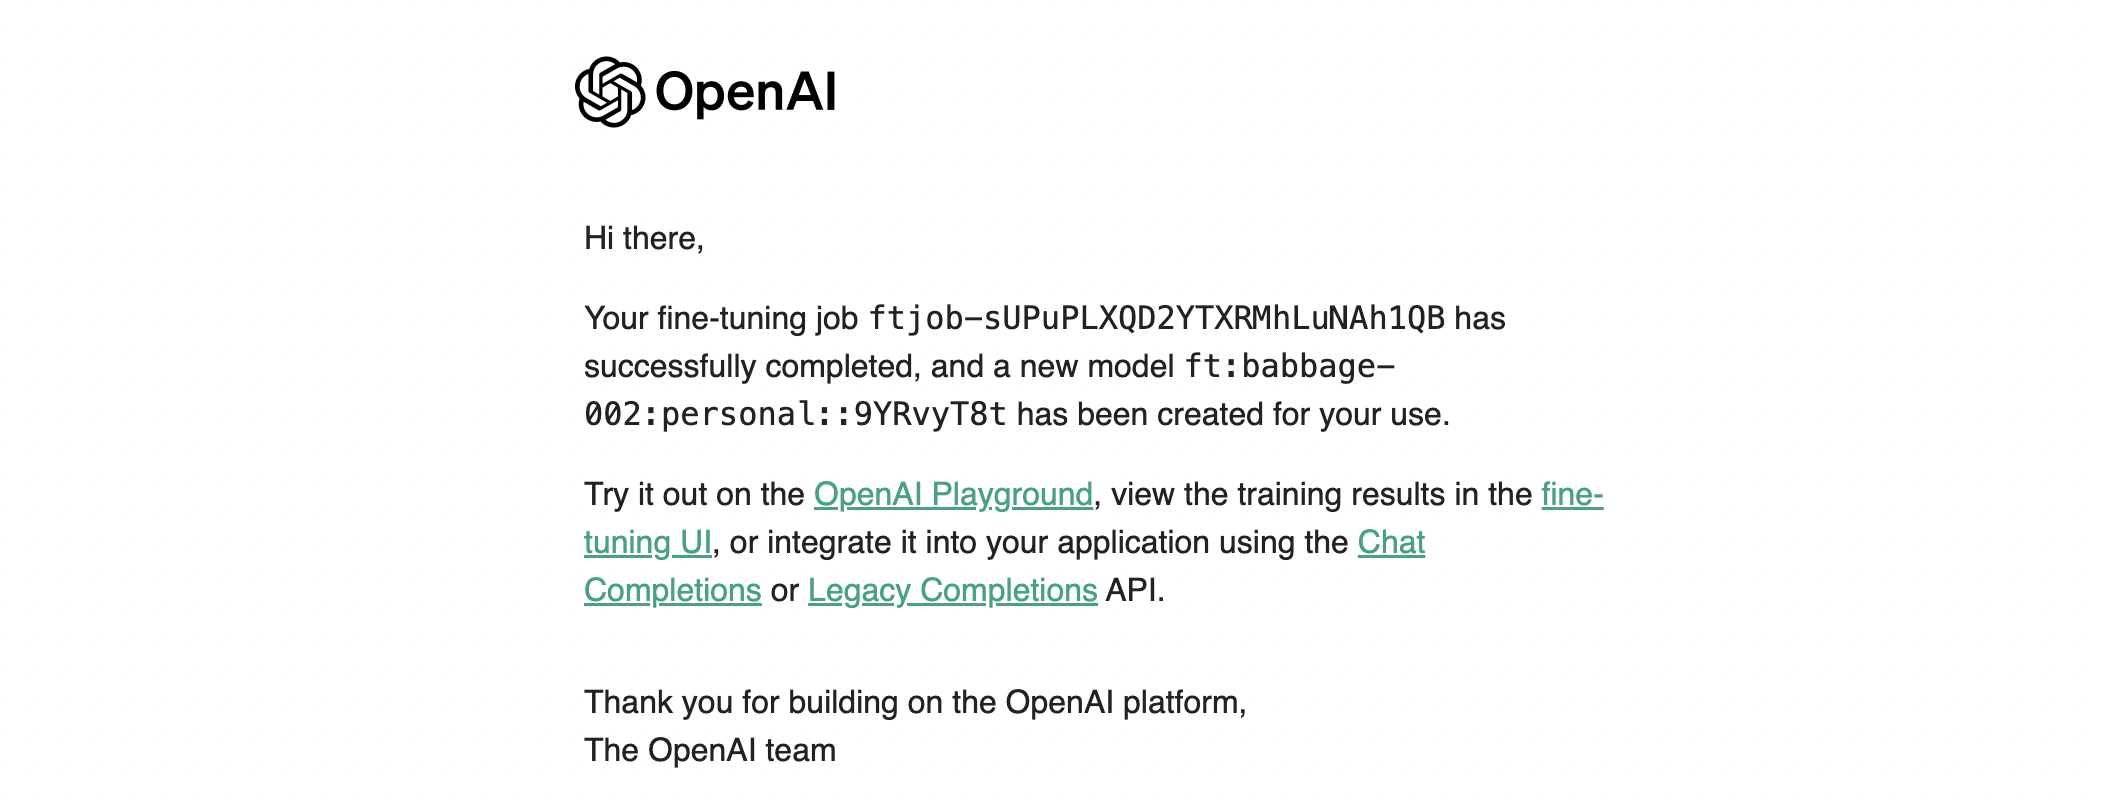

In [20]:
if len(job.result_files):
    print(job.result_files)

['file-Fp4qYUIPfqFZTnMcF1Qjoqxf']


#### 각 코드의 의미와 사용된 함수 설명

1. **`client.fine_tuning.jobs.create`**:
   - 이 함수는 새로운 fine-tuning 작업을 시작한다.
   - 매개변수:
     - `training_file`: 학습에 사용할 파일의 ID.
     - `validation_file`: 검증에 사용할 파일의 ID.
     - `model`: fine-tuning할 기본 모델. 예: "babbage-002".
     - `hyperparameters`: 학습에 사용할 하이퍼파라미터. 예: `{'n_epochs': 1}`.

2. **`client.fine_tuning.jobs.retrieve`**:
   - 이 함수는 특정 fine-tuning 작업의 세부 정보를 가져온다.
   - 매개변수:
     - `job.id`: 조회할 작업의 ID.

이 코드는 OpenAI의 API를 사용하여 모델의 fine-tuning을 시작하고, 진행 중이거나 완료된 작업의 세부 정보를 조회한다. `client.fine_tuning.jobs.create` 함수는 새로운 fine-tuning 작업을 시작하고, `client.fine_tuning.jobs.retrieve` 함수는 특정 작업의 상태나 세부 정보를 가져오는 데 사용된다.

In [28]:
import base64
# OpenAI API를 사용하여 완료된 fine-tuning 작업의 결과를 csv 파일로 저장한다.
results = client.files.retrieve_content(job.result_files[0])
decoded_content = base64.b64decode(results).decode('utf-8')

with open('results.csv', 'w') as f:
    f.write(decoded_content)

<ipython-input-28-2e5f8077a0b4>:7: DeprecationWarning: The `.content()` method should be used instead
  results = client.files.retrieve_content(job.result_files[0])


In [29]:
results_df = pd.read_csv('results.csv')
results_df.head()

,step,train_loss,train_accuracy,valid_loss,valid_mean_token_accuracy
0,1,2.41357,0.43333,NaN,NaN
1,2,2.34330,0.43333,NaN,NaN
2,3,2.43398,0.35556,NaN,NaN
3,4,2.22815,0.42222,NaN,NaN
4,5,2.05190,0.44444,NaN,NaN


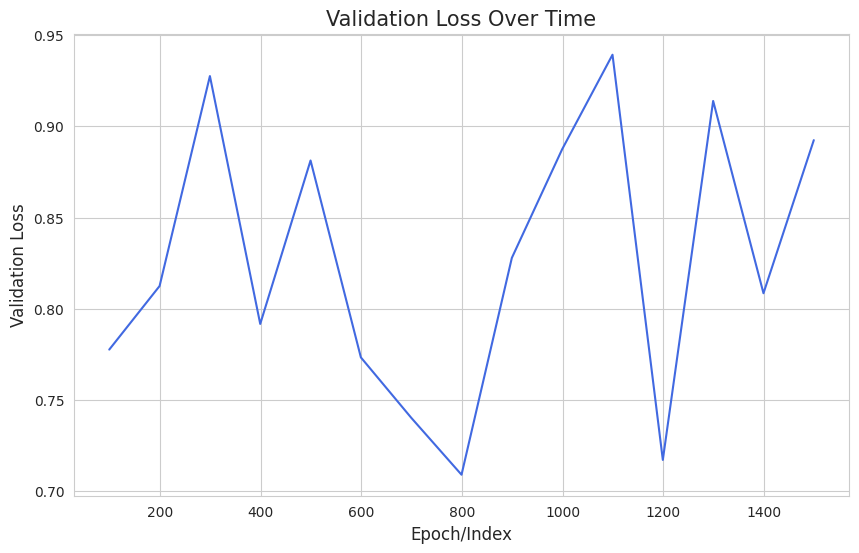

In [30]:
# 'results_df' DataFrame에서 'valid_loss' 값의 그래프를 그린다.
# 원활한 plot을 그리기 위해 NaN 값은 없애준다.
plt.figure(figsize=(10, 6))
results_df['valid_loss'].dropna().plot(color='royalblue')

plt.title('Validation Loss Over Time', fontsize=15)
plt.xlabel('Epoch/Index', fontsize=12)
plt.ylabel('Validation Loss', fontsize=12)

plt.show()

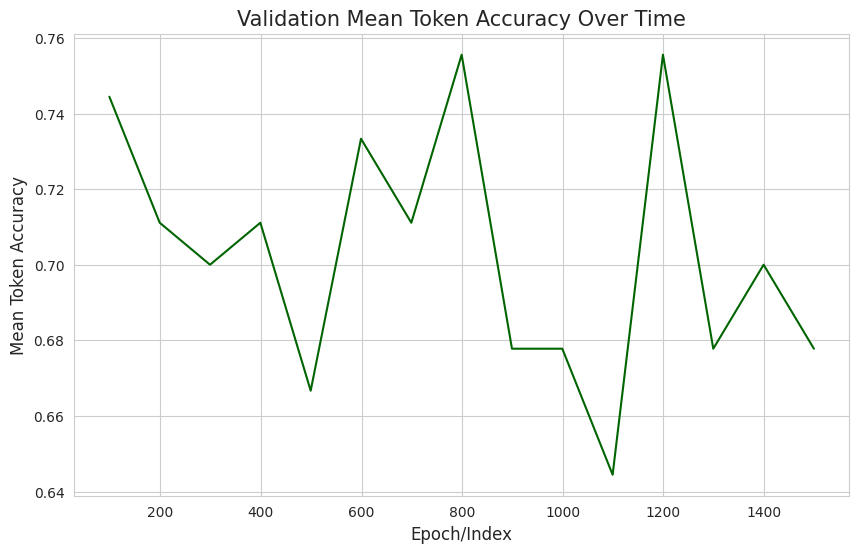

In [32]:
# 'valid_mean_token_accuracy' 값을 'results_df' DataFrame로부터 그려준다.
plt.figure(figsize=(10, 6))
results_df['valid_mean_token_accuracy'].dropna().plot(color="darkgreen")

plt.title('Validation Mean Token Accuracy Over Time', fontsize=15)
plt.xlabel('Epoch/Index', fontsize=12)
plt.ylabel('Mean Token Accuracy', fontsize=12)

plt.show()

### Further fine-tune our Babbage model for 3 more epochs

In [34]:
training_file_id = 'file-cXoUIAvR950JwnmpR7Deuyni'
validation_file_id = 'file-lG5FNLyoHoKJi3qDnHNetvLE'
finetuned_model = 'ft:babbage-002:personal::9YRvyT8t'

In [37]:
job = client.fine_tuning.jobs.create(
    training_file=training_file_id,
    validation_file=validation_file_id,
    model=finetuned_model,
    hyperparameters={'n_epochs': 3}
)

In [38]:
job.id

'ftjob-Noo2dBmuV4gcSrHwQgUR5kKe'

#### Fine-tuning 끝난 뒤 정보 불러오기
- 클라이언트 재설정 후 ID 불러오기

In [3]:
OPENAI_API_KEY = ''
client = OpenAI(api_key=OPENAI_API_KEY)
OpenAI.api_key = OPENAI_API_KEY

In [4]:
job_id = 'ftjob-Noo2dBmuV4gcSrHwQgUR5kKe'
job = client.fine_tuning.jobs.retrieve(job_id)
print(job)

results_df = None
if len(job.result_files):
    print(job.result_files)
    results = client.files.retrieve_content(job.result_files[0])
    decoded_results = base64.b64decode(results).decode('utf-8')
    with open('results_epoch_3.csv', 'w') as f:
        f.write(decoded_results)
    results_df = pd.read_csv('results_epoch_3.csv')

results_df.head()

FineTuningJob(id='ftjob-Noo2dBmuV4gcSrHwQgUR5kKe', created_at=1717999530, error=Error(code=None, message=None, param=None), fine_tuned_model='ft:babbage-002:personal::9YSgvX1K', finished_at=1718000468, hyperparameters=Hyperparameters(n_epochs=3, batch_size=128, learning_rate_multiplier=16), model='ft:babbage-002:personal::9YRvyT8t', object='fine_tuning.job', organization_id='org-jhjkkpJY9RZ329bCHIEIrEYr', result_files=['file-OZRk1qCslpX23nfSoLkUfN2e'], seed=1757271480, status='succeeded', trained_tokens=8500671, training_file='file-cXoUIAvR950JwnmpR7Deuyni', validation_file='file-lG5FNLyoHoKJi3qDnHNetvLE', estimated_finish=None, integrations=[], user_provided_suffix=None)
['file-OZRk1qCslpX23nfSoLkUfN2e']


<ipython-input-4-902f08983419>:8: DeprecationWarning: The `.content()` method should be used instead
  results = client.files.retrieve_content(job.result_files[0])


,step,train_loss,train_accuracy,valid_loss,valid_mean_token_accuracy
0,1,0.64075,0.75000,NaN,NaN
1,2,0.77578,0.68750,NaN,NaN
2,3,0.74652,0.73438,NaN,NaN
3,4,0.70780,0.77344,NaN,NaN
4,5,0.70957,0.75000,NaN,NaN


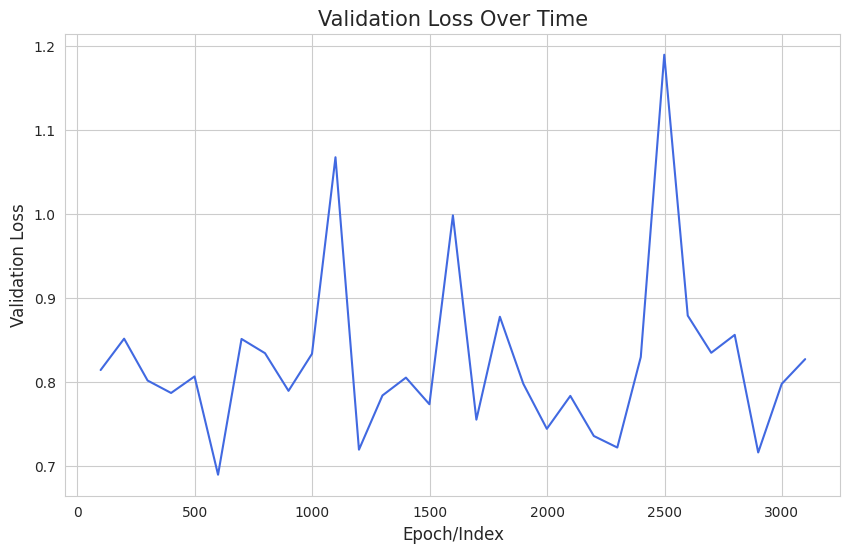

In [5]:
# 'results_df' DataFrame에서 'valid_loss' 값의 그래프를 그린다.
# 원활한 plot을 그리기 위해 NaN 값은 없애준다.
plt.figure(figsize=(10, 6))
results_df['valid_loss'].dropna().plot(color='royalblue')

plt.title('Validation Loss Over Time', fontsize=15)
plt.xlabel('Epoch/Index', fontsize=12)
plt.ylabel('Validation Loss', fontsize=12)

plt.show()

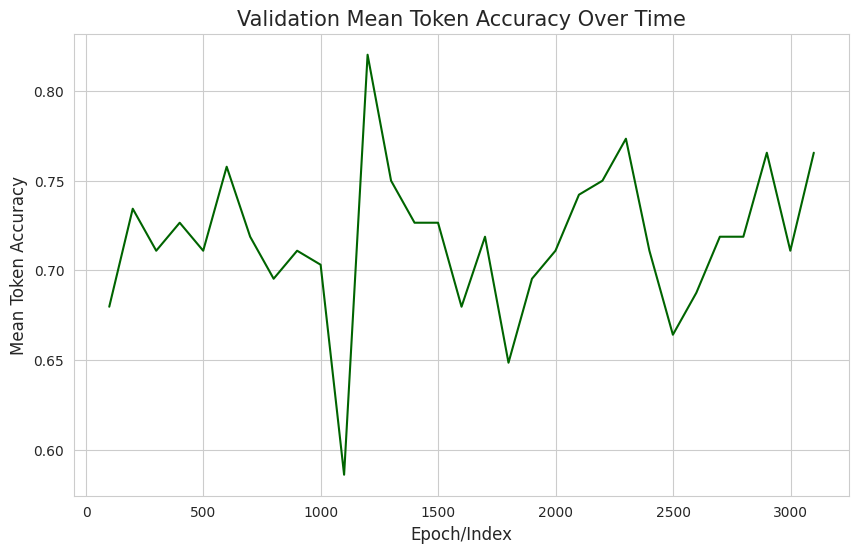

In [6]:
# 'valid_mean_token_accuracy' 값을 'results_df' DataFrame로부터 그려준다.
plt.figure(figsize=(10, 6))
results_df['valid_mean_token_accuracy'].dropna().plot(color="darkgreen")

plt.title('Validation Mean Token Accuracy Over Time', fontsize=15)
plt.xlabel('Epoch/Index', fontsize=12)
plt.ylabel('Mean Token Accuracy', fontsize=12)

plt.show()

크게 성능의 변화가 이루어지지 않는다..

### Let's see what happens if the data was sorted by star

레거시 API에서는 데이터를 업로드하기 전에 데이터를 직접 섞어야 했다.  

fine-tuning으로 인해 성능이 심각하게 저하될 수 있음

사실인지 한번해본다.

In [7]:
# 정렬된 별점의 데이터셋 파일을 업로드 해준다.
ordered_training_file = client.files.create(
    file=open("app-review-full-train-sentiment-ordered.jsonl", "rb"),
    purpose='fine-tune'
)

In [19]:
ordered_training_file_id = 'file-HG4RmKSkR0QTmlSFfaBmbtPs'
validation_file_id = 'file-lG5FNLyoHoKJi3qDnHNetvLE'

In [20]:
# 정렬된 별점 데이터셋을 사용해서 fine-tuning을 진행해본다.
job = client.fine_tuning.jobs.create(
    training_file=ordered_training_file_id,
    validation_file=validation_file_id,
    model='babbage-002',
    hyperparameters={'n_epochs': 1}
)

#### Fine-tuning 끝난 뒤 정보 불러오기
- 클라이언트 재설정 후 ID 불러오기

In [2]:
OPENAI_API_KEY = ''
client = OpenAI(api_key=OPENAI_API_KEY)
OpenAI.api_key = OPENAI_API_KEY

In [6]:
job_id = 'ftjob-JfEy47L81iQXkuzJs57qvgZJ'
job = client.fine_tuning.jobs.retrieve(job_id)
print(job)

result_df = None
if len(job.result_files):
    print(job.result_files)
    results = client.files.retrieve_content(job.result_files[0])
    decoded_results = base64.b64decode(results).decode('utf-8')
    with open('results_sorted_epoch_1.csv', 'w') as f:
        f.write(decoded_results)
    results_df = pd.read_csv('results_sorted_epoch_1.csv')

results_df.head(5)

FineTuningJob(id='ftjob-JfEy47L81iQXkuzJs57qvgZJ', created_at=1718001924, error=Error(code=None, message=None, param=None), fine_tuned_model='ft:babbage-002:personal::9YTBXvGi', finished_at=1718002365, hyperparameters=Hyperparameters(n_epochs=1, batch_size=90, learning_rate_multiplier=16), model='babbage-002', object='fine_tuning.job', organization_id='org-jhjkkpJY9RZ329bCHIEIrEYr', result_files=['file-qkLkHsqvV1aNjhjMPwxoJNoX'], seed=226689138, status='succeeded', trained_tokens=2833557, training_file='file-HG4RmKSkR0QTmlSFfaBmbtPs', validation_file='file-lG5FNLyoHoKJi3qDnHNetvLE', estimated_finish=None, integrations=[], user_provided_suffix=None)
['file-qkLkHsqvV1aNjhjMPwxoJNoX']


<ipython-input-6-66df03bbf270>:8: DeprecationWarning: The `.content()` method should be used instead
  results = client.files.retrieve_content(job.result_files[0])


,step,train_loss,train_accuracy,valid_loss,valid_mean_token_accuracy
0,1,2.58728,0.33333,NaN,NaN
1,2,2.34417,0.42222,NaN,NaN
2,3,2.37793,0.33333,NaN,NaN
3,4,2.39212,0.32222,NaN,NaN
4,5,2.16141,0.40000,NaN,NaN


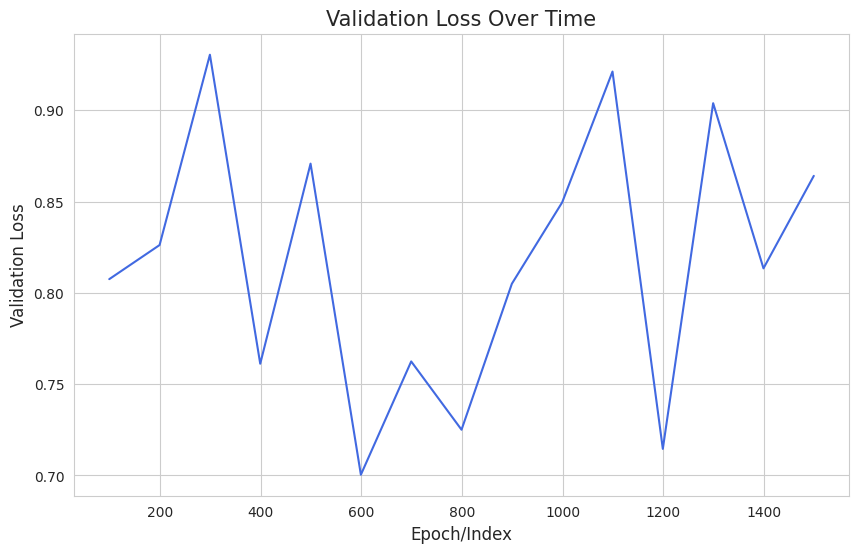

In [7]:
# 'results_df' DataFrame에서 'valid_loss' 값의 그래프를 그린다.
# 원활한 plot을 그리기 위해 NaN 값은 없애준다.
plt.figure(figsize=(10, 6))
results_df['valid_loss'].dropna().plot(color='royalblue')

plt.title('Validation Loss Over Time', fontsize=15)
plt.xlabel('Epoch/Index', fontsize=12)
plt.ylabel('Validation Loss', fontsize=12)

plt.show()

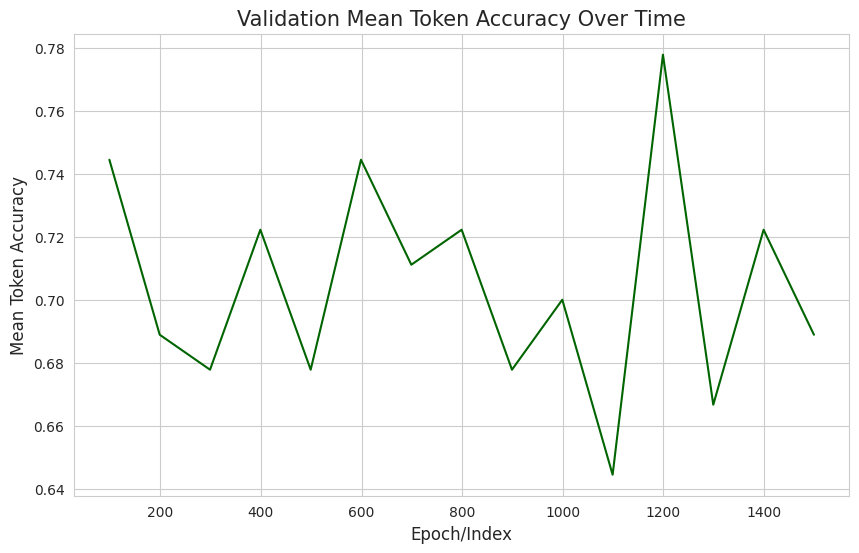

In [8]:
# 'valid_mean_token_accuracy' 값을 'results_df' DataFrame로부터 그려준다.
plt.figure(figsize=(10, 6))
results_df['valid_mean_token_accuracy'].dropna().plot(color="darkgreen")

plt.title('Validation Mean Token Accuracy Over Time', fontsize=15)
plt.xlabel('Epoch/Index', fontsize=12)
plt.ylabel('Mean Token Accuracy', fontsize=12)

plt.show()

거의 같은 결과인 것 같다.

### 3.5 training - first with no system prompt

In [9]:
# 데이터를 불러온 뒤 구조를 확인한다.
json.loads(open("app-review-full-train-sentiment-random-3.5.jsonl", "rb").readlines()[0])

{'messages': [{'role': 'system', 'content': ''},
  {'role': 'user', 'content': 'Nice😉'},
  {'role': 'assistant', 'content': '4'}]}

In [10]:
# 우리의 GPT 3.5 training, validation data 업로드
training_file_3_5 = client.files.create(
    file=open("app-review-full-train-sentiment-random-3.5.jsonl", "rb"),
    purpose='fine-tune'
)

val_file_3_5 = client.files.create(
    file=open("app-review-full-val-sentiment-random-3.5.jsonl", "rb"),
    purpose='fine-tune'
)

In [11]:
job = client.fine_tuning.jobs.create(
    training_file=training_file_3_5.id,
    validation_file=val_file_3_5.id,
    model='gpt-3.5-turbo',
    hyperparameters={'n_epochs': 1}
)

#### Fine-tuning 끝난 뒤 정보 불러오기
- 클라이언트 재설정 후 ID 불러오기

In [3]:
OPENAI_API_KEY = ''
client = OpenAI(api_key=OPENAI_API_KEY)
OpenAI.api_key = OPENAI_API_KEY

In [6]:
job_id = 'ftjob-dud9SvUDdCVjCpOsnfEhzWlc'
job = client.fine_tuning.jobs.retrieve(job_id)
print(job)

result_df = None
if len(job.result_files):
    print(job.result_files)
    results = client.files.retrieve_content(job.result_files[0])
    decoded_results = base64.b64decode(results).decode('utf-8')
    with open('results_sorted_epoch_1.csv', 'w') as f:
        f.write(decoded_results)
    results_df = pd.read_csv('results_sorted_epoch_1.csv')

results_df.head(5)

FineTuningJob(id='ftjob-dud9SvUDdCVjCpOsnfEhzWlc', created_at=1718002616, error=Error(code=None, message=None, param=None), fine_tuned_model='ft:gpt-3.5-turbo-0125:personal::9YY55Sdp', finished_at=1718021186, hyperparameters=Hyperparameters(n_epochs=1, batch_size=115, learning_rate_multiplier=2), model='gpt-3.5-turbo-0125', object='fine_tuning.job', organization_id='org-jhjkkpJY9RZ329bCHIEIrEYr', result_files=['file-up8wqfXu5U9s0W059sqpURO5', 'file-iqUjKcnBjnecJ93Ttt8n2tLV'], seed=2065807338, status='succeeded', trained_tokens=4985412, training_file='file-qYDzHFqDLtCUPXTbwwZdAUwJ', validation_file='file-8PoSRrXzhkbmb4hVC6YMXzKf', estimated_finish=None, integrations=[], user_provided_suffix=None)
['file-up8wqfXu5U9s0W059sqpURO5', 'file-iqUjKcnBjnecJ93Ttt8n2tLV']


<ipython-input-6-2a29b63f781a>:8: DeprecationWarning: The `.content()` method should be used instead
  results = client.files.retrieve_content(job.result_files[0])


,step,train_loss,train_accuracy,valid_loss,valid_mean_token_accuracy
0,1,4.56280,0.64058,NaN,NaN
1,2,3.75106,0.63768,NaN,NaN
2,3,4.29723,0.64058,NaN,NaN
3,4,4.16304,0.64348,NaN,NaN
4,5,4.30085,0.64058,NaN,NaN


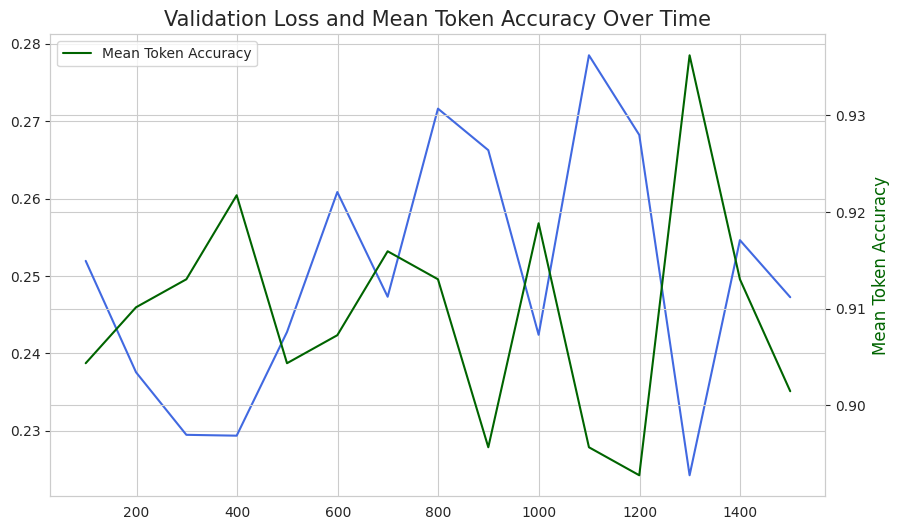

In [7]:
# 'results_df' DataFrame에서 'valid_loss'와 'valid_mean_token_accuracy' 값의 그래프를 그린다.
# 원활한 plot을 그리기 위해 NaN 값은 없애준다.
valid_loss = results_df['valid_loss'].dropna()
valid_mean_token_accuracy = results_df['valid_mean_token_accuracy'].dropna()

plt.figure(figsize=(10, 6))

plt.plot(valid_loss, color="royalblue", label='Validation Loss')
plt.twinx() # 동일한 x축을 공유하는 두 번째 y축을 생성한다.
plt.plot(valid_mean_token_accuracy, color="darkgreen", label='Mean Token Accuracy')

plt.title('Validation Loss and Mean Token Accuracy Over Time', fontsize=15)
plt.xlabel('Epoch/Index', fontsize=12)
plt.ylabel('Validation Loss', fontsize=12, color='royalblue')
plt.ylabel('Mean Token Accuracy', fontsize=12, color='darkgreen')
plt.legend(loc='upper left')

plt.show()

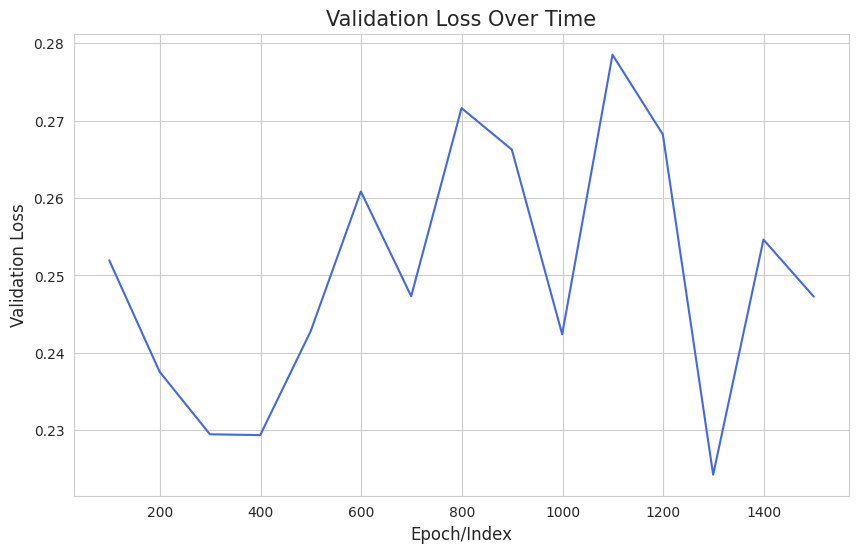

In [8]:
# 'results_df' DataFrame에서 'valid_loss' 값의 그래프를 그린다.
# 원활한 plot을 그리기 위해 NaN 값은 없애준다.
plt.figure(figsize=(10, 6))
results_df['valid_loss'].dropna().plot(color='royalblue')

plt.title('Validation Loss Over Time', fontsize=15)
plt.xlabel('Epoch/Index', fontsize=12)
plt.ylabel('Validation Loss', fontsize=12)

plt.show()

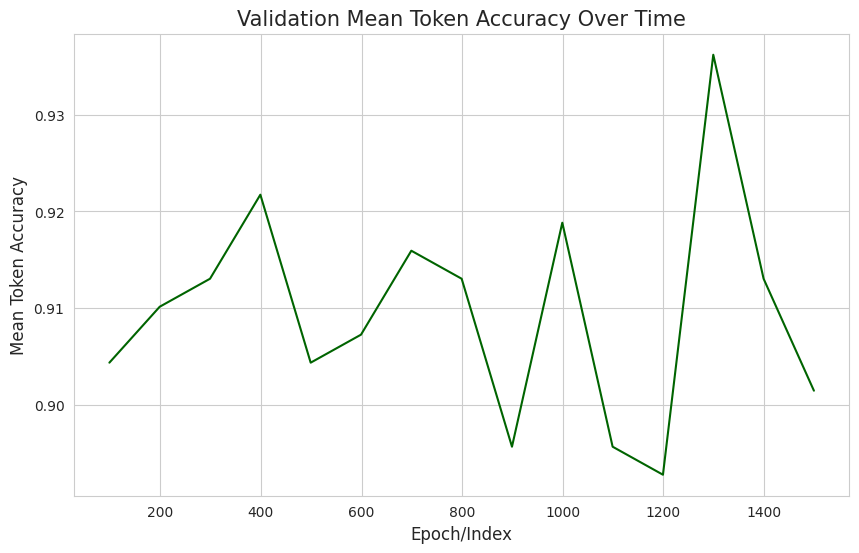

In [9]:
# 'valid_mean_token_accuracy' 값을 'results_df' DataFrame로부터 그려준다.
plt.figure(figsize=(10, 6))
results_df['valid_mean_token_accuracy'].dropna().plot(color="darkgreen")

plt.title('Validation Mean Token Accuracy Over Time', fontsize=15)
plt.xlabel('Epoch/Index', fontsize=12)
plt.ylabel('Mean Token Accuracy', fontsize=12)

plt.show()

### 3.5 training with a system prompt
- limit 초과..



In [12]:
# 시스템을 포함하는 우리의 GPT 3.5 training, validation data 업로드
training_file_3_5_system = client.files.create(
  file=open("app-review-full-train-sentiment-random-3.5-system.jsonl", "rb"),
  purpose='fine-tune'
)

val_file_3_5_system = client.files.create(
  file=open("app-review-full-val-sentiment-random-3.5-system.jsonl", "rb"),
  purpose='fine-tune'
)

In [4]:
training_file_3_5_system_id = 'file-HBRcWt9DLX362L4m2FAvONaC'
val_file_3_5_system_id = 'file-8PoSRrXzhkbmb4hVC6YMXzKf'

In [5]:
job = client.fine_tuning.jobs.create(
    training_file=training_file_3_5_system_id,
    validation_file=val_file_3_5_system_id,
    model='gpt-3.5-turbo',
    hyperparameters={'n_epochs': 1}
)

BadRequestError: Error code: 400 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details.', 'type': 'invalid_request_error', 'param': None, 'code': 'exceeded_quota'}}

#### Fine-tuning 끝난 뒤 정보 불러오기
- 클라이언트 재설정 후 ID 불러오기

In [ ]:
OPENAI_API_KEY = ''
client = OpenAI(api_key=OPENAI_API_KEY)
OpenAI.api_key = OPENAI_API_KEY

In [ ]:
job_id = ''
job = client.fine_tuning.jobs.retrieve(job_id)
print(job)

result_df = None
if len(job.result_files):
    print(job.result_files)
    results = client.files.retrieve_content(job.result_files[0])
    decoded_results = base64.b64decode(results).decode('utf-8')
    with open('results_sorted_epoch_1.csv', 'w') as f:
        f.write(decoded_results)
    results_df = pd.read_csv('results_sorted_epoch_1.csv')

results_df.head(5)

In [ ]:
# 'results_df' DataFrame에서 'valid_loss'와 'valid_mean_token_accuracy' 값의 그래프를 그린다.
# 원활한 plot을 그리기 위해 NaN 값은 없애준다.
valid_loss = results_df['valid_loss'].dropna()
valid_mean_token_accuracy = results_df['valid_mean_token_accuracy'].dropna()

plt.figure(figsize=(10, 6))

plt.plot(valid_loss, color="royalblue", label='Validation Loss')
plt.twinx() # 동일한 x축을 공유하는 두 번째 y축을 생성한다.
plt.plot(valid_mean_token_accuracy, color="darkgreen", label='Mean Token Accuracy')

plt.title('Validation Loss and Mean Token Accuracy Over Time', fontsize=15)
plt.xlabel('Epoch/Index', fontsize=12)
plt.ylabel('Validation Loss', fontsize=12, color='royalblue')
plt.ylabel('Mean Token Accuracy', fontsize=12, color='darkgreen')
plt.legend(loc='upper left')

plt.show()

### Evalauting our classifier using test accuracy

In [10]:
import numpy as np

# fine-tuned 모델을 실행하고 모델의 응답을 얻는 함수를 정의한다.
def run_ft_model(review, ft_id, system='', chat=False):
    """
    리뷰와 fine-tuned 모델 ID를 받아서 OpenAI의 Completion API를 사용하여
    응답을 생성하는 함수이다. 또한, 생성된 응답에 대한 상위 로그 확률 값의 지수 값을 계산한다.

    매개변수:
    - review (str): 리뷰 텍스트.
    - ft_id (str): fine-tuned 모델 ID.

    반환값:
    - str: 모델이 생성한 응답.
    - dict: 토큰과 그에 해당하는 상위 로그 확률 값의 지수로 변환된 값의 딕셔너리.
    """

    # OpenAI의 API를 사용하여 fine-tuned 모델을 사용해 응답을 생성한다.
    if chat:
        completion = client.chat.completions.create(
            model=ft_id,
            messages=[
                {'role': 'system', 'content': system},
                {'role': 'user', 'content': review}
            ],
            max_tokens=1,
            temperature=0.1
        )
        text = completion.choices[0].message.content.strip()
        return text, None
    else:
        completion = client.completions.create(
            model=ft_id,                    # fine-tuned 모델 ID를 지정한다.
            prompt=f'{review}\n###\n',      # 리뷰를 프롬프트 구조로 형식화한다.
            max_tokens=1,                   # 응답을 1 토큰으로 제한한다 (분류 작업에 유용).
            temperature=0.1,                # 결정적인 출력을 위한 설정.
            logprobs=5                      # 응답에 대한 상위 5개의 로그 확률 값을 요청한다.
        )

        # 모델의 응답 텍스트를 추출하고 불필요한 공백을 제거한다.
        text = completion.choices[0].text.strip()

        # 로그 확률 값을 지수 함수로 변환하여 일반 확률 값으로 변환한다.
        # 이는 모델의 응답에 대한 신뢰도를 보다 명확히 이해할 수 있도록 한다.
        probs = {k: np.exp(v) for k, v in completion.choices[0].logprobs.top_logprobs[-1].items()}

        return text, probs

In [13]:
# 사용법 예시: 주어진 리뷰에 대해 fine-tuned 모델을 사용하여 감정 및 관련 확률을 예측한다.
review = 'I hated this thing it was the worst'
ft_id = 'ft:babbage-002:personal::9YTBXvGi'
run_ft_model(review=review, ft_id=ft_id)

RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}